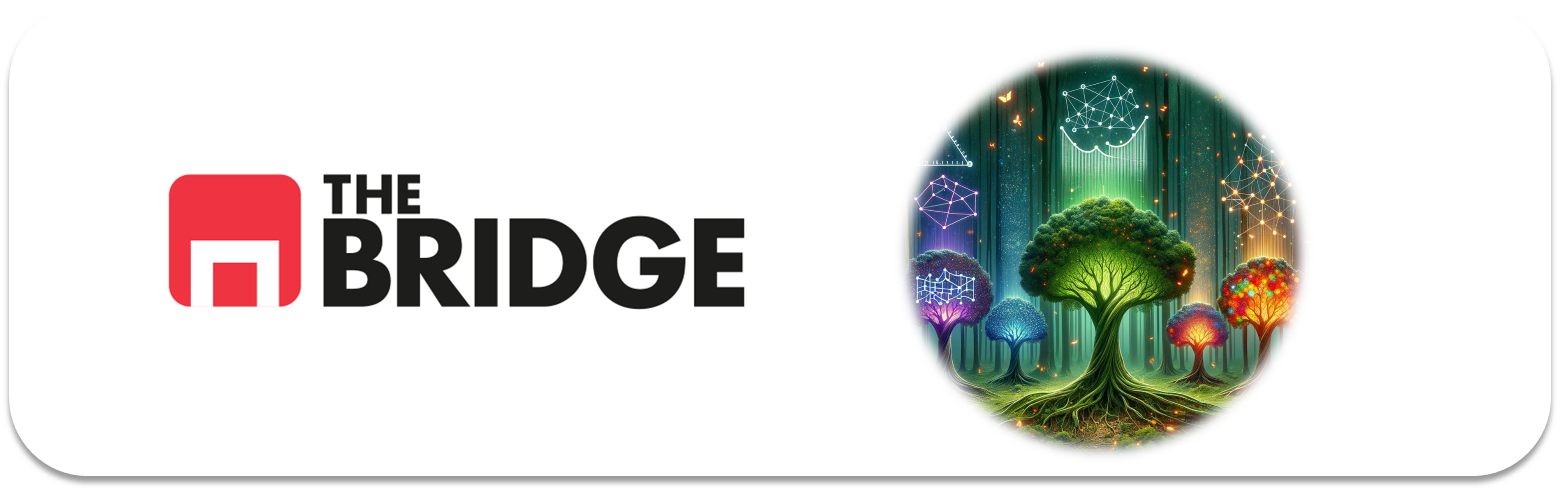

## PRACTICA OBLIGATORIA: **Arboles de Decisión y Ajuste de hiperparámetros**

* La práctica obligatoria de esta unidad consiste en encontrar el mejor modelo para resolver un problema de predicción de si los destinatarios de una campaña de marketing adquirirán un producto concreto. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [94]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr, chi2, chi2_contingency,f_oneway, spearmanr, pearsonr
from sklearn.feature_selection import f_regression
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor


# Configurar pandas para mostrar todas las filas y columnas
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


np.random.seed(5)


%matplotlib inline
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### Descripción

En el directorio data encontrarás un dataset que contiene datos relacionados con campañas de marketing directo de una institución bancaria portuguesa (es el dataset "Bank Marketing" de la UCI Machine Learning Repository). Los datos se recopilaron de campañas de marketing telefónico, donde el objetivo principal era predecir si el cliente se suscribiría a un depósito a plazo.

In [49]:
df = pd.read_csv('./data/bank-full.csv', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


La práctica consiste en completar el proceso de creación de un modelo basado en árboles de decisión que permita predecir si un cliente (dadas unas características similares a las del dataset) "comprará" el depósito a plazo. Sigue los pasos necesarios de un proceso de ML para crear el modelo, optimizar sus hiperparámetros, comparar los resultados de esa optimización con una regresión logística (sin optimizar, con sus hiperparámetros por defecto) y finalmente evaluarlo contra test y hacer una pequeña valoración del resultado obtenido.

Tendrás que hacer la limpieza, split, minieda, selección, tratamiento, primeros entrenamientos, optimización, comparación y evaluación según tu mejor criterio. Eso sí, es obligatorio:
- Identificar el target y analizar su distribución
- Realizar una optimización de hiperparámetros, escogiendo un grid medianemante razonado
- Comparar con el modelo baseline
- Evaluar contra test

AYUDA: La dirección del banco nos proporciona estas notas (en inglés):

 
   **bank client data:**  
   1 - age (numeric)  
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services")   
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)  
   4 - education (categorical: "unknown","secondary","primary","tertiary")  
   5 - default: has credit in default? (binary: "yes","no")  
   6 - balance: average yearly balance, in euros (numeric)   
   7 - housing: has housing loan? (binary: "yes","no")  
   8 - loan: has personal loan? (binary: "yes","no")   

   **related with the last contact of the current campaign:**  
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular")   
  10 - day: last contact day of the month (numeric)  
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")  
  12 - duration: last contact duration, in seconds (numeric)    

   **other attributes:**  
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)  
  15 - previous: number of contacts performed before this campaign and for this client (numeric)  
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

  

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [74]:
df['y'].value_counts(normalize=True)

y
0    0.883015
1    0.116985
Name: proportion, dtype: float64

Vemos que no tenemos Nulos, aunque sí Unknown en algunas columnas. Trabajaremos con ellos como si fueran valores cualquiera dado que nos pueden llegar más casos similares y el hecho de saber o no un dato podría ser significativo.

Como no vamos a tener que imputar valores podemos hacer la "limpieza" de los datos para el modelaje antes de la separación Train - Test.

Teneiendo en mente que la columna target es "y" y es binaria y como observamos tenemos un desbalanceo grande que tendremos que tener en cuenta a la hora de entrenar el modelo. comenzamos con un estudio del data set:

Primero buscamos si alguna columnas que tenga muchas correlación con otra o con la target.

In [56]:
def cat_estandar(df, binarias=True, apply_one_hot=True):
    """
    Clasifica las columnas de un DataFrame según su categoría, transforma las columnas binarias,
    y aplica One-Hot Encoding a las columnas categóricas por defecto.

    Args:
        df: DataFrame de entrada.
        binarias: Puede ser True, False, o una lista de columnas binarias a transformar.
                  True transforma todas las columnas binarias; False no transforma ninguna;
                  una lista transforma solo las columnas especificadas.
        apply_one_hot: Booleano que indica si aplicar One-Hot Encoding a las columnas categóricas (True por defecto).

    Returns:
        Un DataFrame con las transformaciones aplicadas.
    """
    resultado = pd.DataFrame()
    transform_map = {'yes': 1, 'no': 0}
    cols_to_transform = []
    categorical_cols = []

    # Clasificación de columnas y determinación de transformaciones necesarias
    for col in df.columns:
        datos = {}
        if pd.api.types.is_numeric_dtype(df[col]):
            datos['Categoria'] = 'Numerica Continua' if df[col].nunique() > 10 else 'Numérica Discreta'
        else:
            datos['Categoria'] = 'Categórica' if df[col].nunique() > 2 else 'Binaria'
   
        resultado[col] = pd.Series(datos)
        
        if datos['Categoria'] == 'Binaria':
            if binarias is True:
                cols_to_transform.append(col)
            elif isinstance(binarias, list) and col in binarias:
                cols_to_transform.append(col)
        elif datos['Categoria'] == 'Categórica':
            categorical_cols.append(col)
                
    # Transformación de columnas binarias
    for col in cols_to_transform:
        if set(df[col].unique()).issubset(set(transform_map.keys())):
            df[col] = df[col].map(transform_map)
    
    # Aplicación de One-Hot Encoding a columnas categóricas
    if apply_one_hot:
        df = pd.get_dummies(df, columns=categorical_cols, drop_first=False, dtype= int)
    
    return df


In [58]:
df_encoded = cat_estandar(df)
df_encoded.head()

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,0,2143,1,0,5,261,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
1,44,0,29,1,0,5,151,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
2,33,0,2,1,1,5,76,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
3,47,0,1506,1,0,5,92,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
4,33,0,1,0,0,5,198,1,-1,0,...,0,0,1,0,0,0,0,0,0,1


In [59]:
def get_correlated_pairs(df, target_col, umbral_corr=0.5):
    """
    Identifica correlaciones entre cualquier par de columnas en el DataFrame, incluida la columna objetivo,
    y maneja tanto variables numéricas como categóricas.

    Args:
        df: DataFrame para análisis.
        target_col: Nombre de la columna objetivo.
        umbral_corr: Umbral de correlación para considerar significativas las asociaciones.

    Returns:
        Un DataFrame con los pares de columnas correlacionadas, el valor de su correlación y el método utilizado.
    """
    correlated_pairs = []

    for col in df.columns:
        if col != target_col:
            if df[col].dtype in ['float64', 'int64'] and df[target_col].dtype in ['float64', 'int64']:
                correlation, _ = pearsonr(df[col].dropna(), df[target_col].dropna())
                method = 'Pearson'
            elif df[col].dtype == 'object' and df[target_col].dtype == 'object':
                contingency_table = pd.crosstab(df[col], df[target_col])
                _, p_value, _, _ = chi2_contingency(contingency_table)
                correlation = np.sqrt(p_value) if p_value > 0 else 0  # Not a direct correlation measure
                method = 'Chi-square'
            else:
                # Spearman for mixed or ordinal cases
                correlation, _ = spearmanr(df[col], df[target_col], nan_policy='omit')
                method = 'Spearman'
            
            if abs(correlation) >= umbral_corr:
                correlated_pairs.append((col, target_col, correlation, method))

    correlated_df = pd.DataFrame(correlated_pairs, columns=['Column A', 'Column B', 'Correlation', 'Method'])
    return correlated_df

In [60]:
get_correlated_pairs(df_encoded, 'y')

,Column A,Column B,Correlation,Method


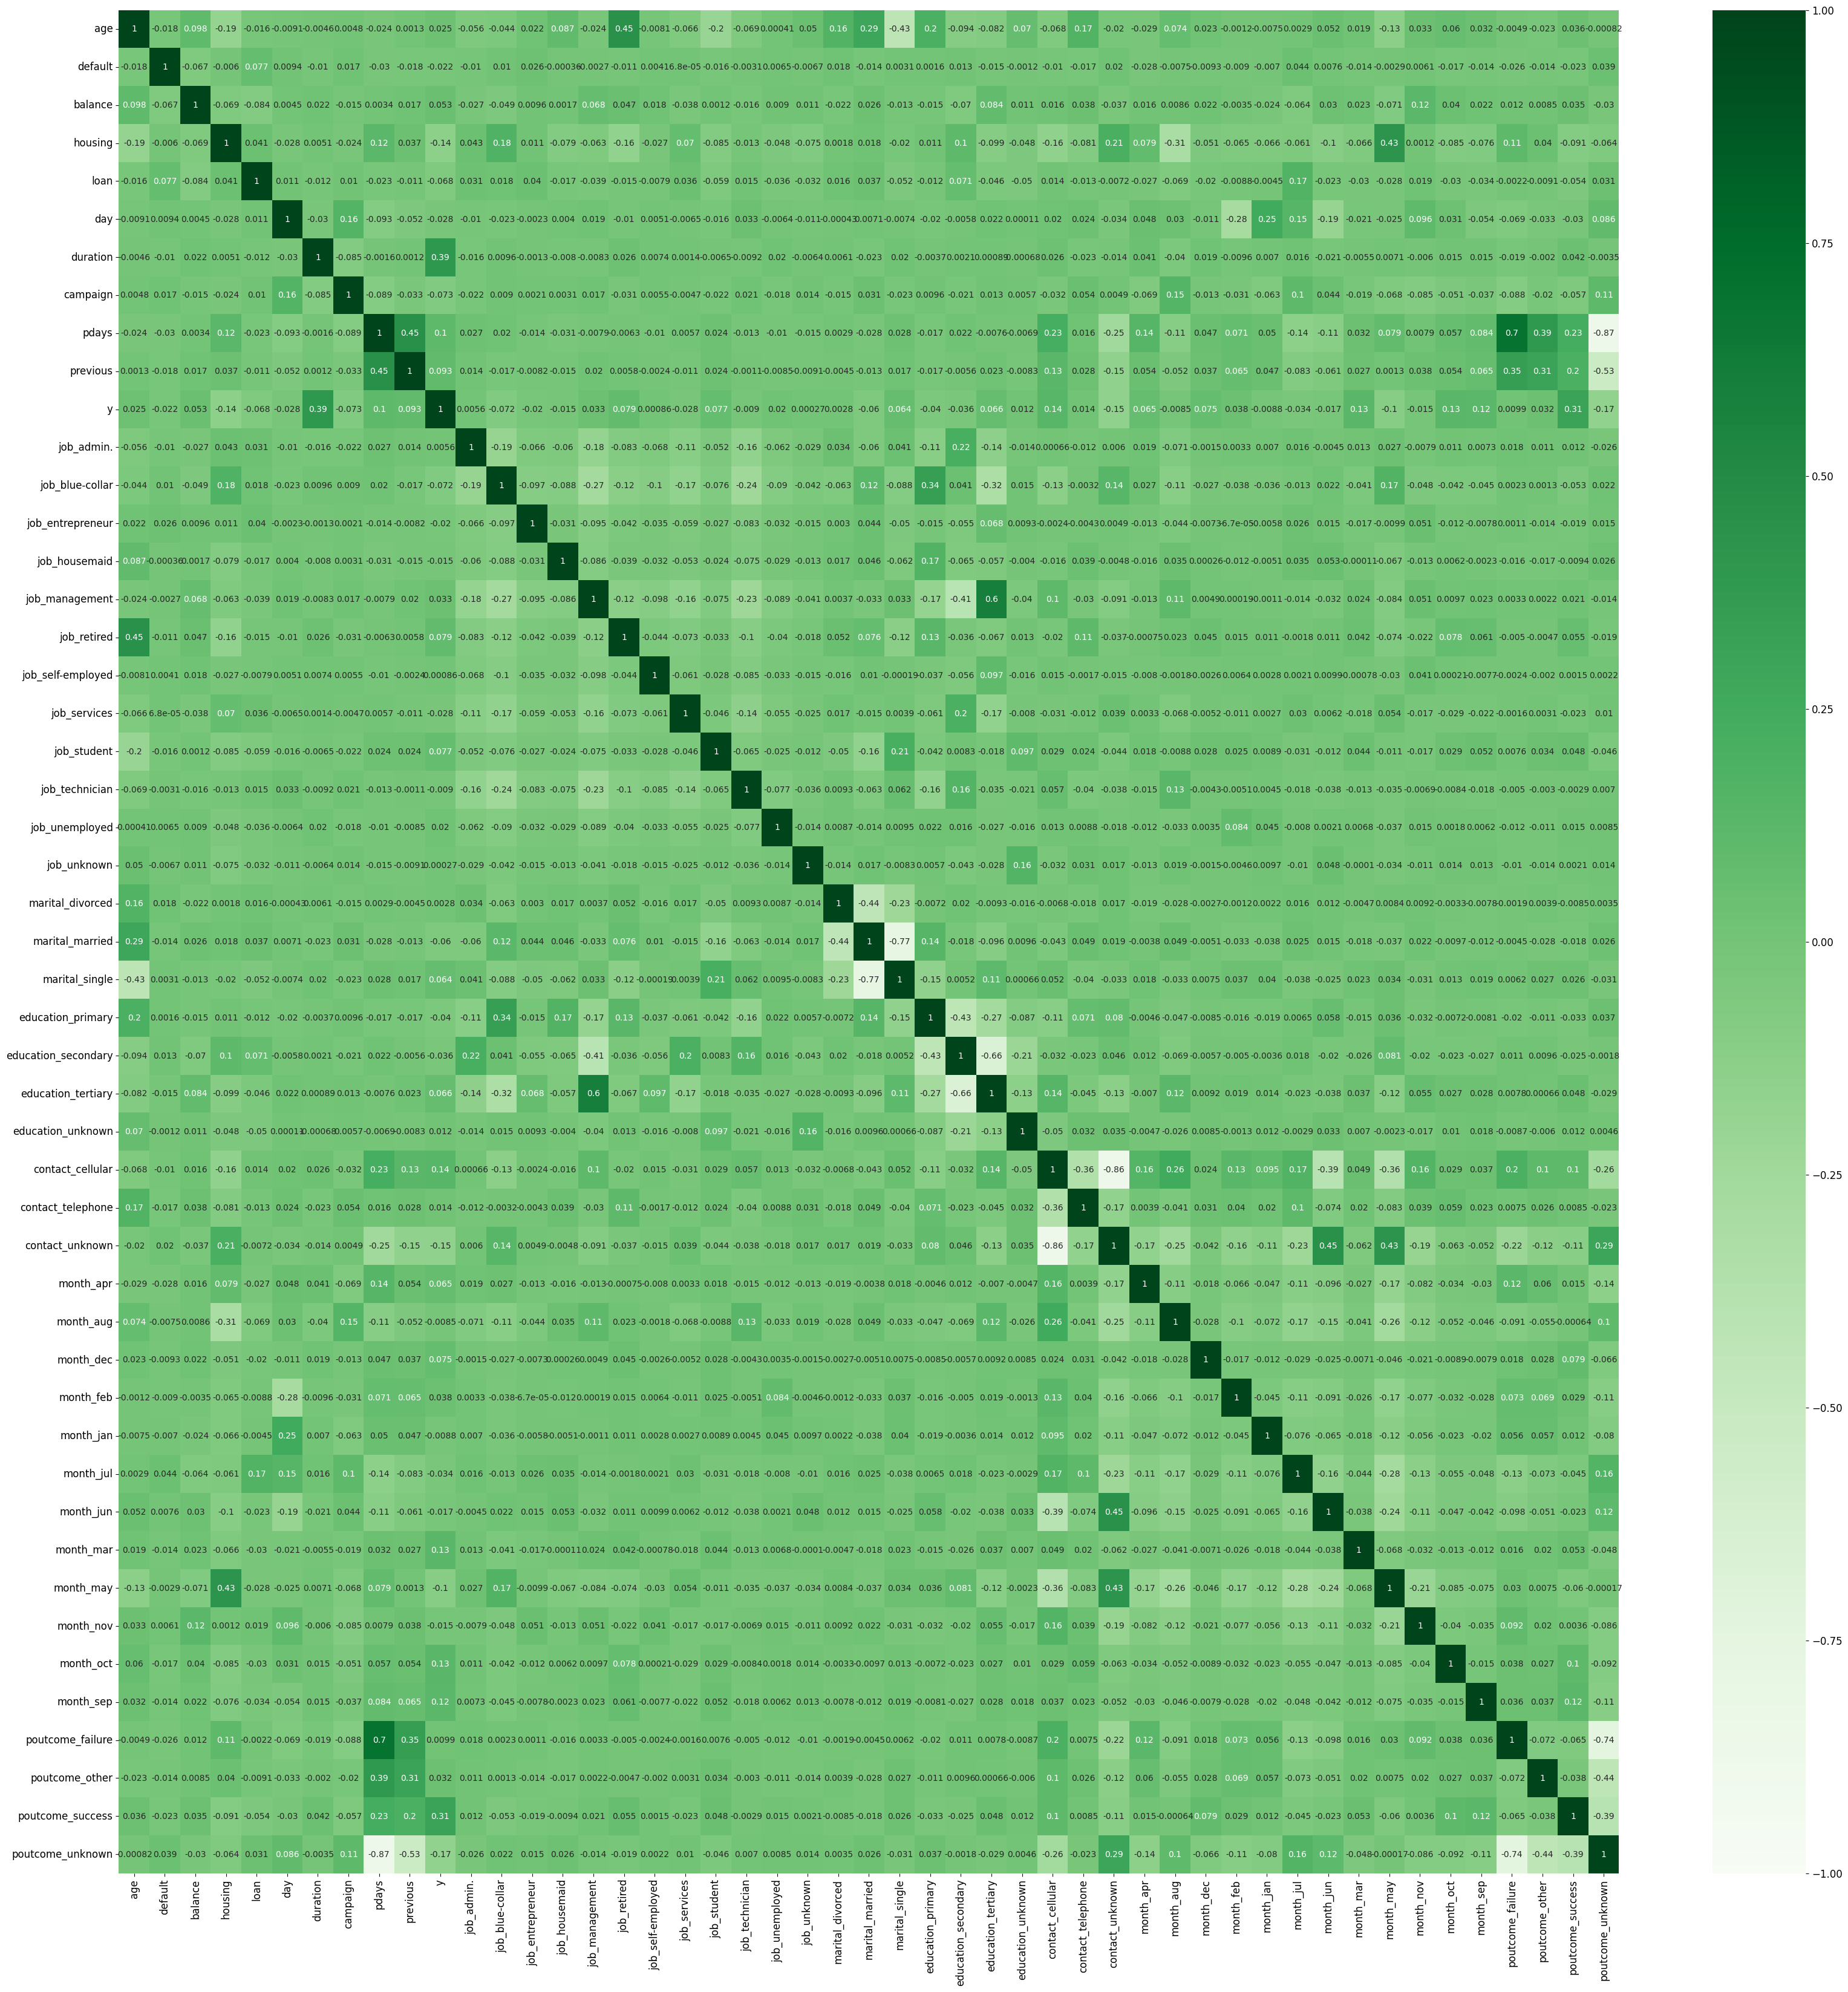

In [61]:
plt.figure(figsize=(40,40))
sns.heatmap(df_encoded.corr(),
           vmin=-1,
           vmax=1,
           cmap="Greens",
           annot=True);

Puesto que hay correlaciones superiores a 0.8, podríamos quitar putcome_unknown y contact_unknown. Pero las vamos a dejar.

Además vemos que ninguna correla a más de 0.5 con la target así que pueden sernos útiles todas. 

In [62]:
train_set, test_set = train_test_split(df_encoded, test_size= 0.2, random_state= 5)

In [63]:
X_train = train_set.drop(columns= ['y'])
y_train = train_set['y']

X_test = test_set.drop(columns = ['y'])
y_test = test_set['y']

In [71]:
def cat_num(df):
    """
    Separa las columnas de un DataFrame en categóricas y numéricas.

    Args:
        df: DataFrame de entrada.

    Returns:
        Una tupla de dos elementos: 
        - El primer elemento es una lista de nombres de columnas categóricas.
        - El segundo elemento es una lista de nombres de columnas numéricas.
    """
    columnas_categoricas = df.select_dtypes(include=['object', 'category']).columns.tolist()
    columnas_numericas = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    return columnas_categoricas, columnas_numericas

In [67]:
col_cat, col_num = cat_num(train_set)

Ahora que tenemos todo limpio y preparado modelamos:

In [72]:
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)

DecisionTreeRegressor()

In [77]:
y_pred = tree.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      7997
           1       0.47      0.46      0.47      1046

    accuracy                           0.88      9043
   macro avg       0.70      0.70      0.70      9043
weighted avg       0.88      0.88      0.88      9043



Ahora vamos a buscar los mejores hyper parámetros para optimizar el modelo:

Empezamos con un RandomSearch

In [79]:
param_grid = {
    'alpha': [1e-10, 1e-4, 1e-2, 1, 5, 10, 20, 40],
    'l1_ratio': np.arange(0,1,0.01)
}

elastic = ElasticNet()

random_search = RandomizedSearchCV(elastic, # El modelo que quiero entrenar
                                   param_grid, # El grid de parámetros
                                   random_state=1, # Semilla
                                   n_iter=100, # Nº de iteraciones del random search
                                   cv=5, # Folds del cross validation
                                   scoring="neg_root_mean_squared_error", # Métrica que quiero optimizar
                                   n_jobs = -1 # Paralelizar
                                  )

random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=ElasticNet(), n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': [1e-10, 0.0001, 0.01, 1, 5, 10,
                                                  20, 40],
                                        'l1_ratio': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])},
                   random_state=1, scoring='neg_root_mean_squared_error')

In [92]:
best_random = random_search.best_estimator_
best_random

ElasticNet(alpha=0.0001, l1_ratio=0.2)

In [89]:
random_search.best_estimator_.score(X_test, y_test)

0.3049521830091134

In [91]:
random_search.best_score_**2

0.07265984856853354

Ahora con GridSearch:

In [95]:
param_grid = {
    'alpha': [1e-10, 1e-4, 1e-2, 1, 5, 10, 20, 40],
    'l1_ratio': np.arange(0, 1, 0.01)
}

elastic = ElasticNet()

grid_search = GridSearchCV(elastic,
                           param_grid,
                           cv=5,
                           scoring='r2',
                           n_jobs=-1
                          )

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=ElasticNet(), n_jobs=-1,
             param_grid={'alpha': [1e-10, 0.0001, 0.01, 1, 5, 10, 20, 40],
                         'l1_ratio': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])},
             scoring='r2')

In [96]:
grid_search.best_estimator_.score(X_test, y_test)

0.30495029762161174

Ahora con el Bayesiano:

In [97]:
def hyperopt_train_test(params, scoring = "r2"):
    model = ElasticNet(**params)
    return cross_val_score(model, X_train, y_train, 
                           cv=5, scoring= scoring).mean() # Aquí la métrica es r2 pero podemos poner la que queramos de las admitidas por la validación cruzada de sklearn


# Defininmos el "grid" (hiperparámetros y rango de valores)
space = {
    'alpha': hp.uniform('alpha', 0.0001, 1.0),
    'l1_ratio': hp.uniform('l1_ratio', 0.0001, 1.0)
}

def f(params):
    r2 = hyperopt_train_test(params)
    return {'loss':-r2, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=100, trials=trials)

100%|██████████| 100/100 [00:39<00:00,  2.53trial/s, best loss: -0.29804412845453016]


In [98]:
model_bayes = ElasticNet(alpha=best['alpha'], l1_ratio=best['l1_ratio'])
model_bayes.fit(X_train, y_train)
model_bayes.score(X_test, y_test)

0.30492638230780833